In [1]:
import torch

In [2]:
import json
from tqdm import tqdm
import uuid
import os
import math
import imgviz
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from collections import defaultdict
import json
from PIL import Image
import glob
from transformers import AutoProcessor
from pycocotools.coco import COCO

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def save_json(data, file_path):
    """
    Save a Python dictionary to a JSON file.

    Parameters:
        data (dict): The data to save.
        file_path (str): The path where the JSON file will be saved.
    """
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)
        
def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def visualize_bbox(image, bbox_list, bbox_name_list,bbox_is_relative=True,with_id=False):
    assert len(bbox_list) == len(bbox_name_list), "bbox_list and bbox_name_list must have the same length"
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    if bbox_is_relative:
        # 画像のサイズを取得
        image_width_height = (image.width, image.height)
        # 相対座標を絶対座標に変換
        bbox_list = [bbox_relative_to_absolute(bbox, image_width_height) for bbox in bbox_list]
        
    #bbox_name_listをソート、bbox_listも同じ順番にソート
    # bbox_name_list, bbox_list = zip(*sorted(zip(bbox_name_list, bbox_list), key=lambda x: x[0]))
    # bbox_name_list = list(bbox_name_list)
    # bbox_list = list(bbox_list)
    name_to_label_id_dict = {}
    label_id = 0
    for bbox_name in bbox_name_list:
        if bbox_name not in name_to_label_id_dict:
            name_to_label_id_dict[bbox_name] = label_id
            label_id += 1    
    
    # bbox_listの座標をy1, x1, y2, x2の形式に変換
    bboxes = []
    labels = []
    # label_id = -1
    # old_label = None
    count_object_dict = {}
    id_bbox_name_list = []
    for bbox ,bbox_name in zip(bbox_list, bbox_name_list):
        x1, y1, x2, y2 = bbox
        bboxes.append([y1, x1, y2, x2])
        # if old_label != bbox_name:
        #     label_id += 1
        #     old_label = bbox_name
        label_id = name_to_label_id_dict[bbox_name]
        if bbox_name not in count_object_dict:
            count_object_dict[bbox_name] = 0
        else:
            count_object_dict[bbox_name] += 1
        if with_id:
            bbox_name = f"{bbox_name}_{count_object_dict[bbox_name]}"
            id_bbox_name_list.append(bbox_name)
        labels.append(label_id)
    # bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    
    base_resolution = 100 * 100
    base_font_size = 3
    image_resolution = image.width * image.height
    font_size = int( base_font_size * (image_resolution / base_resolution) ** 0.5)
    
    if with_id:
        bbox_name_list = id_bbox_name_list
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,font_size=font_size,captions=bbox_name_list)

    plt.imshow(image)
    plt.show()

In [ ]:
# def load_txt(file_path):
#     with open(file_path, "r") as f:
#         lines = f.readlines()
#     return [line.strip() for line in lines]

# def load_anno(anno_folder,image_folder_root):
#     anno_label_path_list = glob.glob(os.path.join(anno_folder, "*.txt"))
#     anno_label_list = [load_txt(path) for path in anno_label_path_list]
#     anno_id_list = [os.path.splitext(os.path.basename(path))[0] for path in anno_label_path_list]
#     image_path_list = [os.path.join(f"PASCAL-VOC/ultralytics/images/", os.path.basename(anno_folder), f"{anno_id}.jpg") for anno_id in anno_id_list]

#     for image_path in image_path_list:
#         image_path = os.path.join(image_folder_root, image_path)
#         if not os.path.exists(image_path):
#             print(f"Image not found: {image_path}")
            
#     return anno_id_list, anno_label_list, image_path_list

def anno_label_list_to_bbox_list(coco_dataset,split,is_crowd=False):
    cat_id2name = {c["id"]: c["name"] for c in coco_dataset.loadCats(coco_dataset.getCatIds())}
    bbox_list_list = []
    bbox_name_list_list = []
    image_path_list = []
    anno_id_list = []
    img_ids = coco_dataset.getImgIds()
    all_boxes = {}

    for img_id in tqdm(img_ids, desc=f"scanning dataset"):
        img_info = coco_dataset.loadImgs([img_id])[0]
        for a in coco_dataset.loadAnns(coco_dataset.getAnnIds(imgIds=[img_id], iscrowd=is_crowd)):
            # print(a.keys())
            if img_id not in all_boxes:
                all_boxes[img_id] = []
            # print(a.keys())
            # for key,value in a.items():
            #     print(key, value)
            # break
            x, y, w, h = a["bbox"]
            bbox = [x, y, x + w, y + h]
            relative_bbox = bbox_absolute_to_relative(bbox, (img_info['width'], img_info['height']))
            all_boxes[img_id].append(
                {
                    "bbox": relative_bbox,
                    "category_id": a["category_id"],
                    "category_name": cat_id2name[a["category_id"]],
                    "iscrowd": a.get("iscrowd", False),  # crowdかどうかの情報も追加
                }
            )
        # break
    for anno_id,item in all_boxes.items():
        if len(item) > 0:
            label_list = []
            bbox_list = []

            for anno in item:
                label = anno["category_name"]
                bbox = anno["bbox"]

                # print(label, bbox)
                # print(bbox)
                label_list.append(label)
                bbox_list.append(bbox)
            assert len(label_list) > 0 and len(bbox_list) >0
            bbox_list_list.append(bbox_list)
            bbox_name_list_list.append(label_list)

            img_info = coco_dataset.loadImgs(anno_id)[0]  # 1件だけなので先頭を取る
            file_name = img_info["file_name"]            # 例: "000000391895.jpg"
            image_path = f"mscoco2017/coco/images/{split}2017/{file_name}"
            image_path_list.append(image_path)
            anno_id_list.append(anno_id)
        
    return bbox_list_list, bbox_name_list_list,image_path_list,anno_id_list

def get_one_class_multi_object_anno(anno_id_list, image_path_list,bbox_list_list,bbox_name_list_list):
    anno_id_dict  = {}
    instance_num_list = []
    
    for anno_id, image_path, bbox_list, bbox_name_list in zip(anno_id_list, image_path_list, bbox_list_list, bbox_name_list_list):
        if anno_id not in anno_id_dict:
            anno_id_dict[anno_id] = {
                "image_path": image_path,
            }
        instance_item = {}
    
        for bbox, bbox_name in zip(bbox_list, bbox_name_list):
            if bbox_name not in instance_item:
                instance_item[bbox_name] = []
            instance_item[bbox_name].append(bbox)
        
        instance_num = 0
        for key,value in instance_item.items():
            instance_num += len(value)
        instance_num_list.append(instance_num)
        assert instance_num == len(bbox_list), f"instance_num {instance_num} != len(bbox_list) {len(bbox_list)} for anno_id {anno_id}"
        anno_id_dict[anno_id]["instances"] = instance_item
    
    max_instance_num = max(instance_num_list) if instance_num_list else 0
    min_instance_num = min(instance_num_list) if instance_num_list else 0
    average_instance_num = sum(instance_num_list) / len(instance_num_list) if instance_num_list else 0
    print(f"max_instance_num: {max_instance_num}, min_instance_num: {min_instance_num}, average_instance_num: {average_instance_num}")
    return anno_id_dict

def clip_by_value(x, min_value, max_value):
    return max(min(x, max_value), min_value)

def get_loc_token(image_width_height_list, bbox_list):
    loc_bbox_list = []
    quantized_bbox_list = []
    loc_tokens = ['<loc%04d>' % i for i in range(1024)]
    for image_width_height, bbox in zip(image_width_height_list, bbox_list):
        relative_bbox = bbox_absolute_to_relative(bbox, image_width_height)
        x1 = int(round(relative_bbox[0] * 1023))
        y1 = int(round(relative_bbox[1] * 1023))
        x2 = int(round(relative_bbox[2] * 1023))
        y2 = int(round(relative_bbox[3] * 1023))
        x1 = clip_by_value(x1, 0, 1023)
        y1 = clip_by_value(y1, 0, 1023)
        x2 = clip_by_value(x2, 0, 1023)
        y2 = clip_by_value(y2, 0, 1023)
        loc_bbox_list.append(f"{loc_tokens[y1]}{loc_tokens[x1]}{loc_tokens[y2]}{loc_tokens[x2]}")
        quantized_bbox_list.append([x1, y1, x2, y2])
        
    return loc_bbox_list, quantized_bbox_list

def check_bbox_valid(bbox, box_w_h=[1, 1], min_bbox_size=1e-6):
    x1, y1, x2, y2 = bbox
    if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0:
        print("minus bbox")
        return False
    if x1 > box_w_h[0] or y1 > box_w_h[1] or x2 > box_w_h[0] or y2 > box_w_h[1]:
        print("over bbox")
        return False
    if x1 >= x2 or y1 >= y2:
        print("x1 >= x2 or y1 >= y2")
        return False
    bbox_area = (x2 - x1) * (y2 - y1)
    if bbox_area < min_bbox_size:
        print("under area minimum")
        return False
    return True

def make_object_name_with_loc_dict_per_image(object_name_list: list[str], boxes: list[list[float]], cat_id_2_name:dict, original_w_h:tuple[int,int]=None,sort_mode="SIZE") -> list[str]:
    # print(object_name_list)
    # print(boxes)
    object_name_bboxes_dict = {}
    for obj_name, box in zip(object_name_list, boxes):
        if obj_name not in object_name_bboxes_dict:
            object_name_bboxes_dict[obj_name] = []
        object_name_bboxes_dict[obj_name].append(box)
    
    if original_w_h is None:
        original_w_h = (1, 1)  # Default to (1, 1) if not provided
    

    object_name_with_loc_dict = {}
    instance_num = 0
    for obj_name, box_list in object_name_bboxes_dict.items():
        object_name_with_loc_dict[obj_name] = {"loc_bbox_list": [], "gt_entities_quantized_normalized": [], "gt_entities_normalized": []}
        loc_bbox_list, quantized_bbox_list = get_loc_token([original_w_h]*len(box_list), box_list)
        # print(loc_bbox_list,quantized_bbox_list)
        new_loc_bbox_list = []
        new_quantized_bbox_list = []
        new_box_list = []
        for loc_bbox, quantized_bbox, box in zip(loc_bbox_list, quantized_bbox_list, box_list):
            if check_bbox_valid(quantized_bbox, box_w_h=(1023, 1023), min_bbox_size=1/448*1/448*1023*1023):
                new_loc_bbox_list.append(loc_bbox)
                new_quantized_bbox_list.append(quantized_bbox)
                new_box_list.append(box)
            else:
                print(f"Invalid bbox for object '{obj_name}': {quantized_bbox} in image size {original_w_h}, skipped.")
        if len(new_loc_bbox_list) == 0:
            del object_name_with_loc_dict[obj_name]
            continue
        loc_bbox_list = new_loc_bbox_list
        quantized_bbox_list = new_quantized_bbox_list
        box_list = new_box_list
        # print(len(loc_bbox_list))
        # print(len(quantized_bbox_list))
        # print(len(box_list))
        quantized_loc_bbox_list = [(quantized_bbox,loc_bbox,bbox) for quantized_bbox, loc_bbox, bbox in zip(quantized_bbox_list, loc_bbox_list, box_list)]
        if sort_mode == "L2":
            quantized_loc_bbox_list = sorted(quantized_loc_bbox_list, key=lambda x: x[0][0]**2 + x[0][1]**2)  # Sort by distance from the top-left corner (0,0)
        elif sort_mode == "UDLR":
            quantized_loc_bbox_list = sorted(quantized_loc_bbox_list, key=lambda x: (x[0][1],x[0][0], x[0][2]**2 + x[0][3]**2))  # Sort by left, then up, then distance from the top-left corner (0,0)
        elif sort_mode == "SIZE":
            quantized_loc_bbox_list = sorted(quantized_loc_bbox_list, key=lambda x: (-(x[0][2]-x[0][0])*(x[0][3]-x[0][1]), x[0][1], x[0][0]))  # Sort by size (largest first), then up, then left
        else :
            raise ValueError("sor_mode must be 'L2' or 'UDLR'")
        # print(quantized_loc_bbox_list)
        quantized_bbox_list, loc_bbox_list, box_list = zip(*quantized_loc_bbox_list)
        loc_bbox_list = list(loc_bbox_list)
        quantized_bbox_list = list(quantized_bbox_list)
        box_list = list(box_list)
        quantized_entity = (obj_name, [bbox_absolute_to_relative(quantized_bbox, (1023,1023)) for quantized_bbox in quantized_bbox_list])
        entity = (obj_name, [bbox_absolute_to_relative(bbox, original_w_h) for bbox in box_list])


        object_name_with_loc_dict[obj_name]["loc_bbox_list"] = loc_bbox_list
        object_name_with_loc_dict[obj_name]["gt_entities_quantized_normalized"] = quantized_entity
        object_name_with_loc_dict[obj_name]["gt_entities_normalized"] = entity

        instance_num += len(loc_bbox_list)

    if instance_num == 0:
        return False
    # オブジェクト名で整列
    categorie_id_list = list(cat_id_2_name.keys())
    new_object_name_with_loc_dict = {}
    for c_i in categorie_id_list:
        cat_name = cat_id_2_name[c_i]
        if cat_name in object_name_with_loc_dict:
            new_object_name_with_loc_dict[cat_name] = object_name_with_loc_dict[cat_name]
    assert len(new_object_name_with_loc_dict) == len(object_name_with_loc_dict), "Some object names are missing after sorting."
    object_name_with_loc_dict = new_object_name_with_loc_dict
    
    return object_name_with_loc_dict


# def make_question_and_answer_one_class(object_name, bbox_list):
#     question = f"<image>detect {object_name}"
#     #question = f"<image>detect {object_name} ; "
#     answer = ""
#     for bbox in bbox_list[:-1]:
#         answer += f"{bbox} ; "
#     answer += bbox_list[-1]
#     return question, answer


def make_question_and_answer_unspecified_multi_class(object_name_with_loc_dict,cat_id_2_name, sort_mode="LABEL",out_format="PLAIN"):
    object_name_list = list(object_name_with_loc_dict.keys())
    cat_name_2_id = {v:k for k,v in cat_id_2_name.items()}
    all_entity_name_list = []
    all_loc_list = []
    all_quantized_bbox_list = []
    all_bbox_list = []
    # print(object_name_with_loc_dict)
    if sort_mode == "LABEL":
        for object_name in object_name_list:
            item = object_name_with_loc_dict[object_name]
            loc_list = item["loc_bbox_list"]
            gt_entities_quantized_normalized = item["gt_entities_quantized_normalized"]
            gt_entities_normalized = item["gt_entities_normalized"]
            all_entity_name_list.extend([object_name]*len(loc_list))
            all_loc_list.extend(loc_list)
            quantized_bbox_list = []
            bbox_list = []
            # print(gt_entities_normalized)
            quantized_bbox_list.extend(gt_entities_quantized_normalized[-1])
            bbox_list.extend(gt_entities_normalized[-1])
            all_quantized_bbox_list.extend(quantized_bbox_list)
            all_bbox_list.extend(bbox_list)
    elif sort_mode == "SIZE":
        for_sorted_size_ci_cn_loc_bbox_gt_entities_quantized_normalized_gt_entities_normalized: list[tuple[int, str, str, list, list]] = []
        for object_name in object_name_list:
            item = object_name_with_loc_dict[object_name]
            loc_list = item["loc_bbox_list"]
            gt_entities_quantized_normalized = item["gt_entities_quantized_normalized"]
            gt_entities_normalized = item["gt_entities_normalized"]
            quantized_bbox_list = []
            bbox_list = []
           
            quantized_bbox_list.extend(gt_entities_quantized_normalized[-1])
            bbox_list.extend(gt_entities_normalized[-1])
            
            cat_id = cat_name_2_id[object_name]
            for loc_bbox, quantized_bbox, bbox in zip(loc_list, quantized_bbox_list, bbox_list):
                box_size = (quantized_bbox[2]-quantized_bbox[0])*(quantized_bbox[3]-quantized_bbox[1])
                assert box_size > 0, f"box_size must be positive, but got {box_size} for object '{object_name}' with quantized_bbox {quantized_bbox}"
                for_sorted_size_ci_cn_loc_bbox_gt_entities_quantized_normalized_gt_entities_normalized.append(( box_size, cat_id, object_name, loc_bbox, quantized_bbox, bbox))
        
        for_sorted_size_ci_cn_loc_bbox_gt_entities_quantized_normalized_gt_entities_normalized = sorted(for_sorted_size_ci_cn_loc_bbox_gt_entities_quantized_normalized_gt_entities_normalized, key=lambda x: (-x[0], x[1], x[4][1], x[4][0]))  # Sort by size (largest first), then by category id, then by y1, then by x1
        for _, _, object_name, loc_bbox, quantized_bbox, bbox in for_sorted_size_ci_cn_loc_bbox_gt_entities_quantized_normalized_gt_entities_normalized:
            all_entity_name_list.append(object_name)
            all_loc_list.append(loc_bbox)
            all_quantized_bbox_list.append(quantized_bbox)
            all_bbox_list.append(bbox)
    
    else:
        raise ValueError("sort_model must be 'LABEL' or 'SIZE'")

    # print(len(all_entity_name_list), len(all_loc_list), len(all_quantized_bbox_list), len(all_bbox_list))
    # print(all_bbox_list)
    assert len(all_entity_name_list) == len(all_loc_list) == len(all_quantized_bbox_list) == len(all_bbox_list), "Length mismatch among entity names, locs, quantized bboxes, and bboxes"

    all_object_name_list = list(cat_name_2_id.keys())
    question = f"<image>Detect objects in this image from the following categories: ["
    for index, object_name in enumerate(all_object_name_list):
        if index < len(all_object_name_list) - 1:
            question += f"{object_name} ; "
        else:
            question += f"{object_name}"
    question += "]. List detected categories only."
    #question = f"<image>detect {object_name} ; "
    if out_format == "PLAIN":
            answer = ""
    elif out_format == "CHECK":
        appear_object_list = []
        not_appear_object_list = []
        for object_name in cat_name_2_id.keys():
            if object_name in all_entity_name_list:
                appear_object_list.append(object_name)
            else:
                not_appear_object_list.append(object_name)
        answer = "I can see ["
        for index, object_name in enumerate(appear_object_list):
            if index < len(appear_object_list) - 1:
                answer += f"{object_name} ; "
            else:
                answer += f"{object_name}"
        answer += "] in the image."
        # answer += "], but not ["
        # for index, object_name in enumerate(not_appear_object_list):
        #     if index < len(not_appear_object_list) - 1:
        #         answer += f"{object_name} ; "
        #     else:
        #         answer += f"{object_name}"
        # answer += "] in the image."
    for index, (object_name, loc) in enumerate(zip(all_entity_name_list, all_loc_list)):
        loc = loc
        if index < len(all_entity_name_list) - 1:
            answer += f"{loc} {object_name} ; "
        else:
            answer += f"{loc} {object_name}"
    
    new_gt_entities_quantized_normalized = []
    new_gt_entities_normalized = []
    for object_name, quantized_bbox, bbox in zip(all_entity_name_list, all_quantized_bbox_list, all_bbox_list):
        new_gt_entities_quantized_normalized.append( (object_name, [quantized_bbox]) )
        new_gt_entities_normalized.append( (object_name, [bbox]) )
        
    return question, answer, new_gt_entities_quantized_normalized, new_gt_entities_normalized



def make_conversation(id,image_path,question,answer,gt_entities_quantized_normalized,gt_entities_normalized,image_w_h,anno_id,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ],
        "gt_entities_quantized_normalized": gt_entities_quantized_normalized,
        "gt_entities_normalized": gt_entities_normalized, # for backward compatibility
        "image_width_height": image_w_h,
        "anno_id": anno_id
    }
    return return_data


def make_json_data(split,q_a_func,image_folder_root=None,sort_mode="SIZE", multi_sort_mode="LABEL",out_format="PLAIN"):
    coco_dataset = COCO(f"/data_ssd/mscoco2017/coco/annotations/instances_{split}2017.json")
    cat_id2name = {c["id"]: c["name"] for c in coco_dataset.loadCats(coco_dataset.getCatIds())}
    
    bbox_list_list, bbox_name_list_list,image_path_list,anno_id_list = anno_label_list_to_bbox_list(coco_dataset,split,False)
    print(len(bbox_list_list))
    print(len(bbox_name_list_list))
    print(len(image_path_list))
    print(len(anno_id_list))
    assert len(set(anno_id_list)) == len(anno_id_list)
    assert len(bbox_list_list) == len(bbox_name_list_list) == len(image_path_list) == len(anno_id_list)
    
    save_json_data = []
    for anno_id,bbox_list,bbox_name_list, image_path in tqdm(zip(anno_id_list, bbox_list_list, bbox_name_list_list, image_path_list), total=len(anno_id_list)):
        
        image_w_h_size = Image.open(os.path.join(image_folder_root,image_path)).size  # (width, height)
        if len(bbox_list) == 0 or len(bbox_name_list) == 0:
            print("make_json_data")
            print(bbox_list)
            print(bbox_name_list)
        object_name_with_loc_dict = make_object_name_with_loc_dict_per_image(bbox_name_list, bbox_list,cat_id2name,sort_mode=sort_mode)
        if not object_name_with_loc_dict:
            print(f"anno_id:{anno_id} is not has valid bbox")
            continue
        id = anno_id
        question, answer, gt_entities_quantized_normalized, gt_entities_normalized = q_a_func(object_name_with_loc_dict, cat_id2name, sort_mode=multi_sort_mode, out_format=out_format)
        conversation = make_conversation(id, image_path, question, answer, gt_entities_quantized_normalized, gt_entities_normalized, image_w_h_size, anno_id)
        save_json_data.append(conversation)
            
    return save_json_data
    

In [8]:
split = "val"
anno_path = f"/data_ssd/mscoco2017/coco/annotations/instances_{split}2017.json"

In [9]:
import random

In [10]:
seed = 42
random.seed(seed)
NAME_SUFFIX = "sort_size_cat_label" #"one_class_without_delim" #"one_class_with_delim"
q_a_func =  make_question_and_answer_unspecified_multi_class #make_question_and_answer_one_class_without_delim #make_question_and_answer_one_class_with_delim #make_question_and_answer_one_class_without_delim
sort_mode = "SIZE"  # "L2" or "UDLR" or "SIZE"
multi_sort_mode = "LABEL"  # "LABEL" or "SIZE"
out_format = "PLAIN"  # "PLAIN" or "CHECK"
train_ratio = 0.9
valid_ratio = 0.1
# cat_id2name = {
#   0: "aeroplane",
#   1: "bicycle",
#   2: "bird",
#   3: "boat",
#   4: "bottle",
#   5: "bus",
#   6: "car",
#   7: "cat",
#   8: "chair",
#   9: "cow",
#   10: "diningtable",
#   11: "dog",
#   12: "horse",
#   13: "motorbike",
#   14: "person",
#   15: "pottedplant",
#   16: "sheep",
#   17: "sofa",
#   18: "train",
#   19: "tvmonitor",
# }


# train

In [11]:
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest

image_folder_root = f"/data_ssd"
save_json_data = make_json_data("train", q_a_func, image_folder_root=image_folder_root,sort_mode=sort_mode,multi_sort_mode=multi_sort_mode,out_format=out_format)
  
# for data in tqdm(save_json_data):
#   processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
#   sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
#   caption, entities = processor.post_process_generation(sentence)
#   assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"

print(f"Total data: {len(save_json_data)}")

save_json_path = f"/data_ssd/mscoco-detection/paligemma_actual_detection/train_mscoco2017_actual_detection_for_paligemma_{NAME_SUFFIX}.json"
train_num = int(len(save_json_data) * train_ratio)
valid_num = len(save_json_data) - train_num
assert len(save_json_data[:train_num]) == train_num, "train_num mismatch"
random.shuffle(save_json_data)
save_json(save_json_data[:train_num], save_json_path)                

loading annotations into memory...
Done (t=12.61s)
creating index...
index created!


scanning dataset: 100%|██████████| 118287/118287 [00:04<00:00, 25920.13it/s]


117266
117266
117266
117266


 15%|█▌        | 17762/117266 [00:34<03:13, 513.01it/s]

under area minimum
Invalid bbox for object 'sports ball': [0.45359375, 0.5074166666666666, 0.455859375, 0.509625] in image size (1, 1), skipped.


 15%|█▌        | 17925/117266 [00:34<03:14, 510.61it/s]

x1 >= x2 or y1 >= y2
Invalid bbox for object 'hot dog': [0.463515625, 0.8090208333333333, 0.4651249999999999, 0.8090208333333333] in image size (1, 1), skipped.


 56%|█████▌    | 65548/117266 [02:05<01:46, 487.54it/s]

under area minimum
Invalid bbox for object 'person': [0.867234375, 0.637234375, 0.8690312499999999, 0.6391875] in image size (1, 1), skipped.


 62%|██████▏   | 72267/117266 [02:21<01:17, 580.25it/s]

x1 >= x2 or y1 >= y2
Invalid bbox for object 'person': [0.01559375, 0.43953379953379956, 0.02425, 0.43953379953379956] in image size (1, 1), skipped.


 73%|███████▎  | 85193/117266 [02:45<01:02, 514.32it/s]

under area minimum
Invalid bbox for object 'bird': [0.313375, 0.03075, 0.315125, 0.03391666666666667] in image size (1, 1), skipped.


100%|██████████| 117266/117266 [03:48<00:00, 512.47it/s]


Total data: 117266


# val

In [12]:
save_json_path = f"/data_ssd/mscoco-detection/paligemma_actual_detection/val_mscoco2017_actual_detection_for_paligemma_{NAME_SUFFIX}.json"
save_json(save_json_data[train_num:], save_json_path)

# Test

In [13]:
image_folder_root = f"/data_ssd"
save_json_data = make_json_data("val", q_a_func, image_folder_root=image_folder_root,sort_mode=sort_mode,multi_sort_mode=multi_sort_mode,out_format=out_format)
  
# for data in tqdm(save_json_data):
#   processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
#   sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
#   caption, entities = processor.post_process_generation(sentence)
#   assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"

print(f"Total data: {len(save_json_data)}")

save_json_path = f"/data_ssd/mscoco-detection/paligemma_actual_detection/test_mscoco2017_actual_detection_for_paligemma_{NAME_SUFFIX}.json"
save_json(save_json_data, save_json_path)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


scanning dataset: 100%|██████████| 5000/5000 [00:00<00:00, 46352.35it/s]


4952
4952
4952
4952


100%|██████████| 4952/4952 [00:09<00:00, 529.67it/s]


Total data: 4952


In [4]:
# save_json_data = load_json(save_json_path)
save_json_data = load_json("/data_ssd/mscoco-detection/paligemma_actual_detection/train_mscoco2017_actual_detection_for_paligemma_sort_size_cat_size.json")
save_json_data = load_json("/home/omote/omote-data-ssd/iam-llms-finetune/experiment_output/paligemma_mscoco2017-actual-detection_448px/448px_label_aligned_train-vision-proj-llm_ce_excepted_dfl_2025-11-07T12_09_07/checkpoint-412/eval_output/val_mscoco2017_actual_detection_for_paligemma_sort_size_cat_label/temperature=1.0-top_p=1.0-top_k=50-num_beams=1-do_sample=False-/2025-11-08T00_30_06/eval_output.json")
print(len(save_json_data))
image_folder_root = f"/data_ssd"

11727


In [5]:
import re
def check_bbox_valid(bbox, box_w_h=[1, 1], min_bbox_size=1e-6):
    x1, y1, x2, y2 = bbox
    if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0:
        return False
    if x1 > box_w_h[0] or y1 > box_w_h[1] or x2 > box_w_h[0] or y2 > box_w_h[1]:
        return False
    if x1 >= x2 or y1 >= y2:
        return False
    bbox_area = (x2 - x1) * (y2 - y1)
    if bbox_area < min_bbox_size:
        return False
    return True
def parse_bbox_and_labels(detokenizer_output: str):
    # pattern = r"((<loc\d{4}>){4})[^;<]+|((<loc\d{4}>){4})$"
    # matches = re.findall(pattern, detokenizer_output)
    # print("matches", matches)
    pattern = r"(((<loc\d{4}>){4})([^;<]+))"
    matches = re.findall(pattern, detokenizer_output)
    if len(matches) > 0 and matches[0][-1].strip() != "":
        label_list = []
        bbox_list = []
        for m in matches:
            y1, x1, y2, x2 = [int(x)/1024.0 for x in re.findall(r'\d+', m[1])]
            if check_bbox_valid([x1, y1, x2, y2], box_w_h=[1, 1], min_bbox_size=1e-6):
                bbox_list.append([x1, y1, x2, y2])
                label_list.append(m[-1].strip())
        return bbox_list, label_list

    pattern = r"([^<]+)((<loc\d{4}>){4})"
    matches = re.findall(pattern, detokenizer_output)
    if len(matches) > 0:
        label_pattern = r"^<image>detect\s([^<]+)<loc\d{4}>"
        match = re.findall(label_pattern, detokenizer_output)
        if len(match) > 0 and match[0].strip() != "":
            label = match[0].strip()
            bbox_list = []
            for m in matches:
                y1, x1, y2, x2 = [int(x)/1024.0 for x in re.findall(r'\d+', m[1])]
                if check_bbox_valid([x1, y1, x2, y2], box_w_h=[1, 1], min_bbox_size=1e-6):
                    bbox_list.append([x1, y1, x2, y2])
            label_list = [label] * len(bbox_list)
            return bbox_list, label_list
    
    return [], []


id: 525087
image: mscoco2017/coco/images/train2017/000000525087.jpg
conversations: [{'from': 'human', 'value': '<image>Detect objects in this image from the following categories: [person ; bicycle ; car ; motorcycle ; airplane ; bus ; train ; truck ; boat ; traffic light ; fire hydrant ; stop sign ; parking meter ; bench ; bird ; cat ; dog ; horse ; sheep ; cow ; elephant ; bear ; zebra ; giraffe ; backpack ; umbrella ; handbag ; tie ; suitcase ; frisbee ; skis ; snowboard ; sports ball ; kite ; baseball bat ; baseball glove ; skateboard ; surfboard ; tennis racket ; bottle ; wine glass ; cup ; fork ; knife ; spoon ; bowl ; banana ; apple ; sandwich ; orange ; broccoli ; carrot ; hot dog ; pizza ; donut ; cake ; chair ; couch ; potted plant ; bed ; dining table ; toilet ; tv ; laptop ; mouse ; remote ; keyboard ; cell phone ; microwave ; oven ; toaster ; sink ; refrigerator ; book ; clock ; vase ; scissors ; teddy bear ; hair drier ; toothbrush]. List detected categories only.'}, {'fro

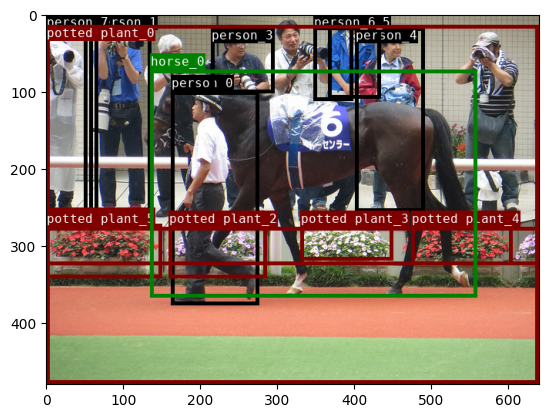

['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'horse', 'handbag', 'handbag', 'tie', 'potted plant', 'potted plant', 'potted plant', 'potted plant', 'potted plant']
ground truth bbox list: [[0.2528125, 0.19775, 0.42978125, 0.7820208333333334], [0.6307031249999999, 0.03929166666666666, 0.7636875, 0.5399166666666667], [0.828171875, 0.0469375, 0.959484375, 0.5416666666666666], [0.090015625, 0.0077083333333333335, 0.20121875, 0.5475], [0.0, 0.011229166666666667, 0.08595312499999999, 0.5393333333333333], [0.44115624999999997, 0.0125625, 0.5796875, 0.23618750000000002], [0.19918750000000002, 0.052083333333333336, 0.318765625, 0.2886875], [0.566296875, 0.0, 0.67078125, 0.2539375], [0.32020312500000003, 0.029541666666666667, 0.45739062500000005, 0.2124375], [0.19929687499999998, 0.14739583333333334, 0.8816875, 0.7647708333333333], [0.85409375, 0.20504166666666668, 0.9495000000000001, 0.3534583333333333], [0.66525, 0.18285416666666665, 0.7492656249999

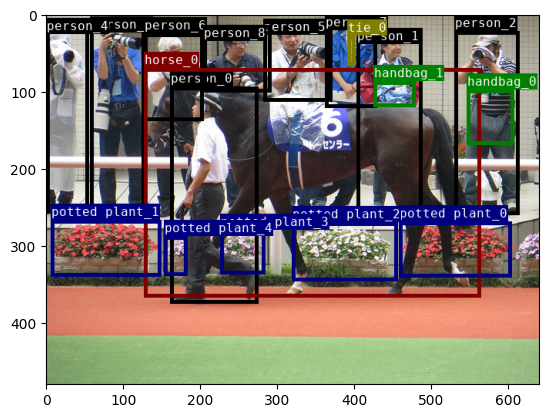

In [6]:
index = -22
index = 4
index = -40
data = save_json_data[index]
for key, value in data.items():
    print(f"{key}: {value}")
print(f"quantized bbox: {np.array(data['gt_entities_quantized_normalized'][0][-1])*1023}")
print(f"quantized normalized bbox: {np.array(data['gt_entities_normalized'][0][-1])*1023}")
image_path = os.path.join(image_folder_root, data["image"])
sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
bbox_list,label_list = parse_bbox_and_labels(sentence)
print(label_list)
print(bbox_list)
visualize_bbox(image_path, bbox_list, label_list, bbox_is_relative=True, with_id=True)
ground_truth_bbox_list = []
for entity in data["gt_entities_normalized"]:
    bbox_list = entity[1]
    for bbox in bbox_list:
        ground_truth_bbox_list.append(bbox)
label_list = [d[0] for d in data["gt_entities_normalized"]]
print(label_list)
print("ground truth bbox list:", ground_truth_bbox_list)
visualize_bbox(image_path, ground_truth_bbox_list, label_list, bbox_is_relative=True, with_id=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


id: 322610
image: mscoco2017/coco/images/val2017/000000322610.jpg
conversations: [{'from': 'human', 'value': '<image>Detect objects in this image from the following categories: [person ; bicycle ; car ; motorcycle ; airplane ; bus ; train ; truck ; boat ; traffic light ; fire hydrant ; stop sign ; parking meter ; bench ; bird ; cat ; dog ; horse ; sheep ; cow ; elephant ; bear ; zebra ; giraffe ; backpack ; umbrella ; handbag ; tie ; suitcase ; frisbee ; skis ; snowboard ; sports ball ; kite ; baseball bat ; baseball glove ; skateboard ; surfboard ; tennis racket ; bottle ; wine glass ; cup ; fork ; knife ; spoon ; bowl ; banana ; apple ; sandwich ; orange ; broccoli ; carrot ; hot dog ; pizza ; donut ; cake ; chair ; couch ; potted plant ; bed ; dining table ; toilet ; tv ; laptop ; mouse ; remote ; keyboard ; cell phone ; microwave ; oven ; toaster ; sink ; refrigerator ; book ; clock ; vase ; scissors ; teddy bear ; hair drier ; toothbrush]. List detected categories only.'}, {'from'

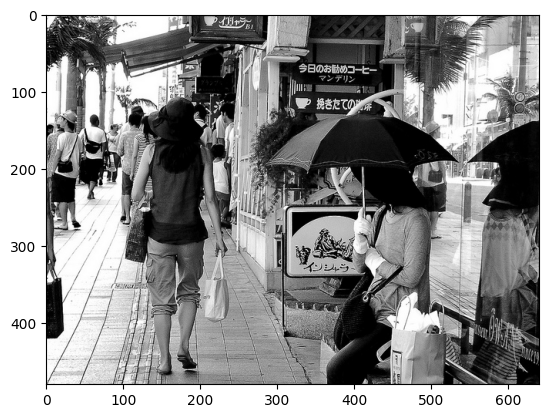

In [12]:
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
index = -22
index = -16
index = -2
data = save_json_data[index]
for key, velue in data.items():
    print(f"{key}: {velue}")
image_path = os.path.join(image_folder_root, data["image"])
sentence = data["conversations"][0]["value"] + data["conversations"][1]["value"]
caption, entities = processor.post_process_generation(sentence)
# assert len(entities) == 1, f"entities must be 1, but got {len(entities)}"
caption_list = []
bbox_list = []
for entity in entities:
    caption_list.extend([entity[0]]*len(entity[-1]))
    bbox_list.extend(entity[-1])
print(bbox_list)
visualize_bbox(image_path, bbox_list, caption_list, bbox_is_relative=True, with_id=True)

In [12]:
print(sentence)
print(processor.tokenizer.tokenize(sentence))
print(entities)

<image>detect person<loc0003><loc0006><loc1018><loc0516> ; <loc0183><loc0509><loc0848><loc0966> ; <loc0194><loc0329><loc0674><loc0557>
['<image>', '▁detect', '▁person', '<', 'loc', '000', '3', '><', 'loc', '000', '6', '><', 'loc', '10', '18', '><', 'loc', '05', '16', '>', '▁;', '▁<', 'loc', '01', '83', '><', 'loc', '05', '09', '><', 'loc', '08', '48', '><', 'loc', '09', '66', '>', '▁;', '▁<', 'loc', '01', '94', '><', 'loc', '03', '29', '><', 'loc', '06', '74', '><', 'loc', '05', '57', '>']
[]


In [13]:
processor = AutoProcessor.from_pretrained("/data_ssd/huggingface_model_weights/microsoft/kosmos-2-patch14-224")
processor.tokenizer.tokenize("</object>|<phrase>")

['</object>', '▁|', '<phrase>']

# データセット作成に当たる検証

In [ ]:
cat_id2name = {
  0: "aeroplane",
  1: "bicycle",
  2: "bird",
  3: "boat",
  4: "bottle",
  5: "bus",
  6: "car",
  7: "cat",
  8: "chair",
  9: "cow",
  10: "diningtable",
  11: "dog",
  12: "horse",
  13: "motorbike",
  14: "person",
  15: "pottedplant",
  16: "sheep",
  17: "sofa",
  18: "train",
  19: "tvmonitor",
}



split = "train"
year = "2012"
#https://panda-clip.com/data-split-stratified/
#trainは2007のtrainと2012のtrainvalを使用
#valは2007のval
#testは2007のtest
anno_folder = f"/data_ssd/PASCAL-VOC/ultralytics/labels/{split}{year}"
image_folder_root = f"/data_ssd"

['2008_000008', '2008_000015', '2008_000019', '2008_000023', '2008_000028']
['12 0.522 0.5712669683257919 0.836 0.7533936651583711', '14 0.445 0.23642533936651586 0.262 0.27828054298642535']


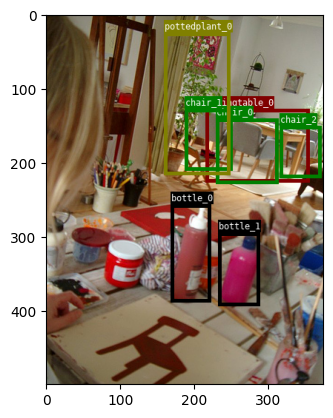

/data_ssd/PASCAL-VOC/ultralytics/images/train2012/2008_008330.jpg
[[0.448, 0.514, 0.592, 0.778], [0.6213333333333333, 0.5900000000000001, 0.768, 0.788], [0.576, 0.256, 0.9466666666666667, 0.45599999999999996], [0.6133333333333333, 0.28200000000000003, 0.8346666666666667, 0.45999999999999996], [0.49866666666666665, 0.256, 0.6693333333333333, 0.42200000000000004], [0.84, 0.302, 0.9893333333333333, 0.442], [0.424, 0.05199999999999999, 0.6613333333333333, 0.434]]
['bottle', 'bottle', 'diningtable', 'chair', 'chair', 'chair', 'pottedplant']


In [6]:
anno_id_list, anno_label_list, image_path_list = load_anno(anno_folder,image_folder_root)
bbox_list_list, bbox_name_list_list = anno_label_list_to_bbox_list(anno_label_list, cat_id2name)

print(anno_id_list[:5])
print(anno_label_list[0])
index = 2000
image_path = os.path.join(image_folder_root, image_path_list[index])
bbox_list = bbox_list_list[index]
bbox_name_list = bbox_name_list_list[index]

visualize_bbox(image_path, bbox_list, bbox_name_list, bbox_is_relative=True, with_id=True)
print(image_path)
print(bbox_list)
print(bbox_name_list)

In [7]:
anno_id_dict = get_one_class_multi_object_anno(anno_id_list, image_path_list, bbox_list_list, bbox_name_list_list)
item = anno_id_dict[anno_id_list[index]]
for key, value in item.items():
    if key == "image_path":
        print(f"{key}: {value}")
    else:
        print(f"{key}:")
        for bbox_name, bbox_list in value.items():
            print(f"  {bbox_name}: {bbox_list}")

max_instance_num: 27, min_instance_num: 1, average_instance_num: 2.380444288962743
image_path: PASCAL-VOC/ultralytics/images/train2012/2008_008330.jpg
instances:
  bottle: [[0.448, 0.514, 0.592, 0.778], [0.6213333333333333, 0.5900000000000001, 0.768, 0.788]]
  diningtable: [[0.576, 0.256, 0.9466666666666667, 0.45599999999999996]]
  chair: [[0.6133333333333333, 0.28200000000000003, 0.8346666666666667, 0.45999999999999996], [0.49866666666666665, 0.256, 0.6693333333333333, 0.42200000000000004], [0.84, 0.302, 0.9893333333333333, 0.442]]
  pottedplant: [[0.424, 0.05199999999999999, 0.6613333333333333, 0.434]]


In [8]:
save_json_data = []
for anno_id,bbox_list,bbox_name_list, image_path in tqdm(zip(anno_id_list, bbox_list_list, bbox_name_list_list, image_path_list), total=len(anno_id_list)):
    
    image_w_h_size = Image.open(os.path.join(image_folder_root,image_path)).size  # (width, height)
    object_name_with_loc_dict = make_object_name_with_loc_dict_per_image(bbox_name_list, bbox_list, image_w_h_size)
    
    for object_name, loc_list in object_name_with_loc_dict.items():
        id = f"{anno_id}_{object_name}"
        question, answer = make_question_and_answer(object_name, loc_list)
        conversation = make_conversation(id, image_path, question, answer, image_w_h_size, anno_id)
        save_json_data.append(conversation)

100%|██████████| 5717/5717 [00:06<00:00, 875.19it/s]


In [9]:
print(len(save_json_data))
print(object_name_with_loc_dict)
print(save_json_data[1])

8331
{'bird': ['<patch_index_0000><patch_index_0000>']}
{'id': '2008_000008_person', 'image': 'PASCAL-VOC/ultralytics/images/train2012/2008_000008.jpg', 'conversations': [{'from': 'human', 'value': '<image><grounding> <phrase> person</phrase>'}, {'from': 'gpt', 'value': '<object><patch_index_0000><patch_index_0000></object>'}], 'image_width_height': (500, 442), 'ann_id': '2008_000008'}


# 作成するデータセット
* 画像ごとに複数クラス、複数物体
* 物体ごとに分けて検出させる
* \<p\>\<p\>まで入力、後は出力